Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 150000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 160000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 170000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 180000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 190000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/chainstore.txt, Min Util: 200000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/accidents_utility_spmf.txt, Min Util: 15000000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/accidents_utility_spmf.txt, Min Util: 16000000 (Already Processed)
Skipping EFIM for File: /home/tarun/cudaEFIM/datasets/accidents_utility_spmf.txt, Min Util: 17000000 (Already Proces

/tmp/ipykernel_77720/3838067725.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Algorithm"] = filtered_df["Algorithm"].apply(lambda x: "cuEFIM" if x == "EFIM" else "DP-Local 16 threads")
/tmp/ipykernel_77720/3838067725.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"] + filtered_df["GPU_Memory_Usage"].fillna(0)
/tmp/ipykernel_77720/3838067725.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

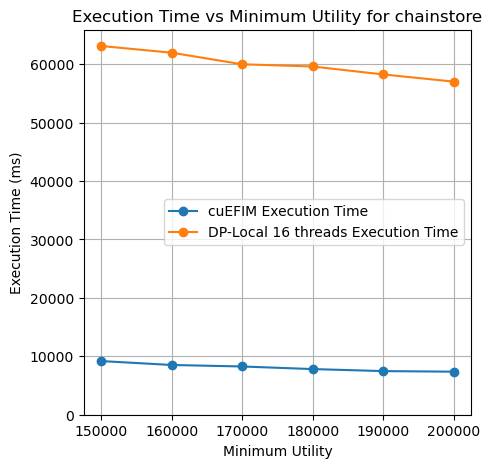

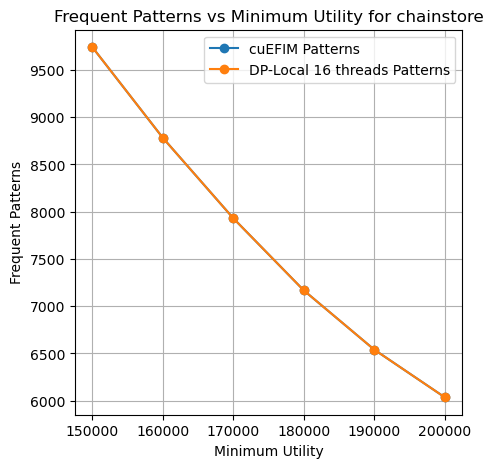

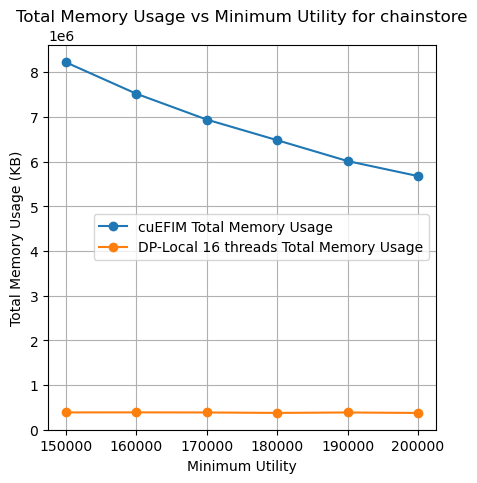

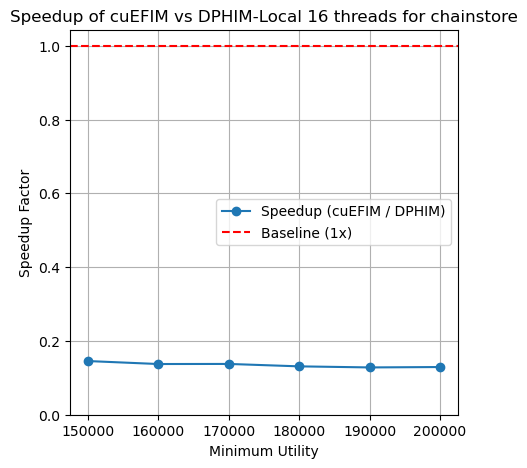

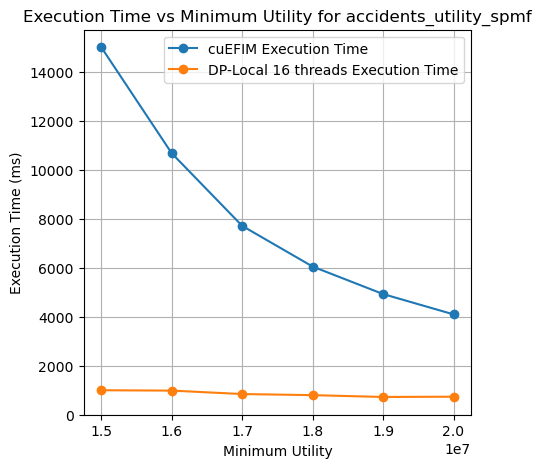

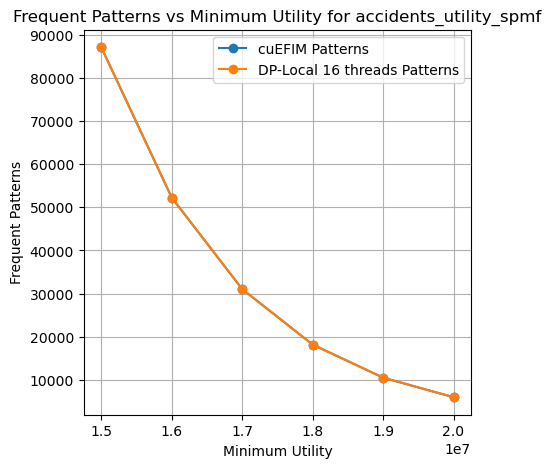

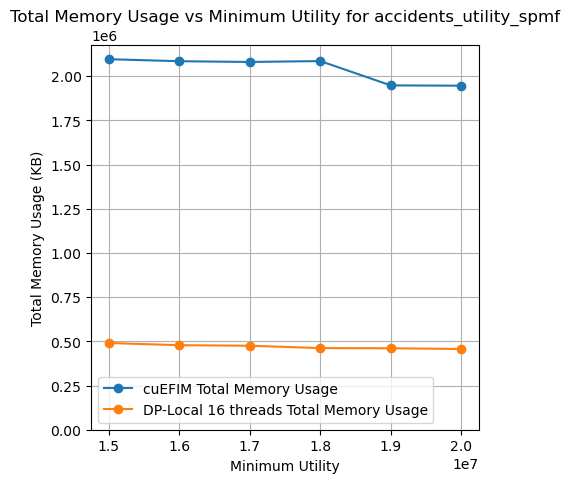

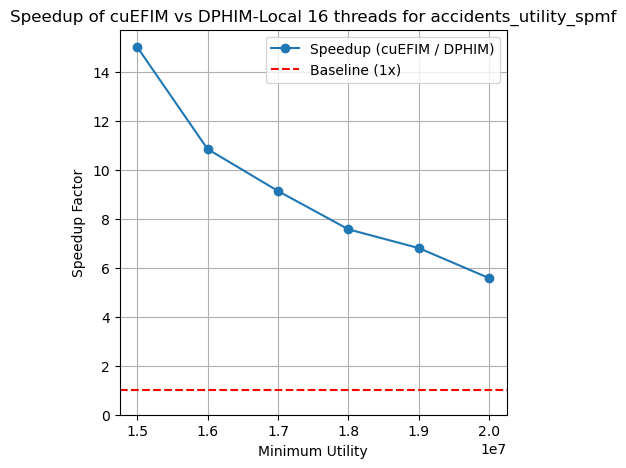

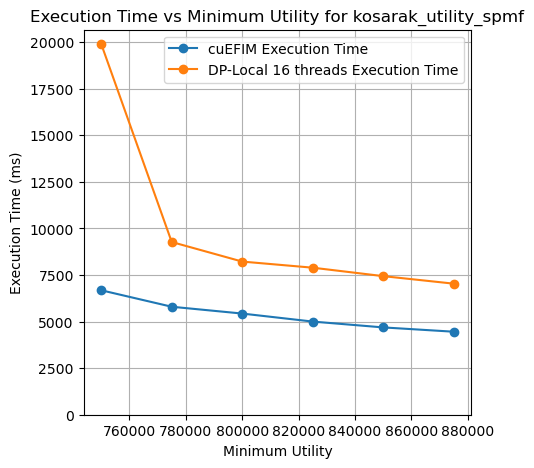

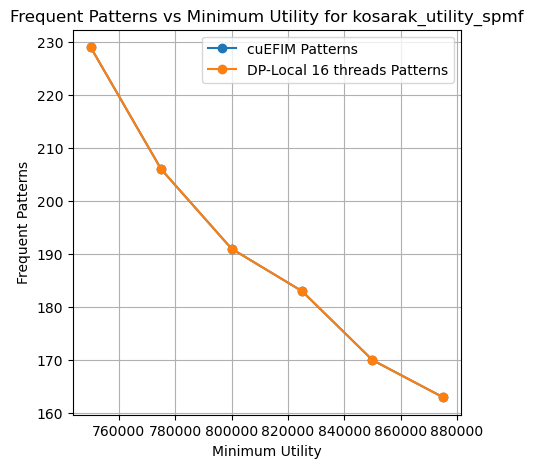

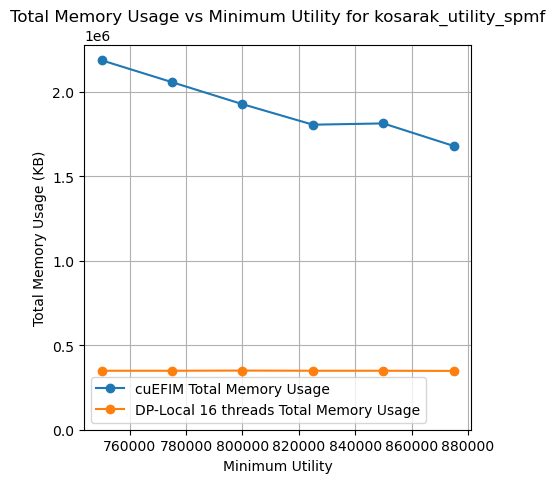

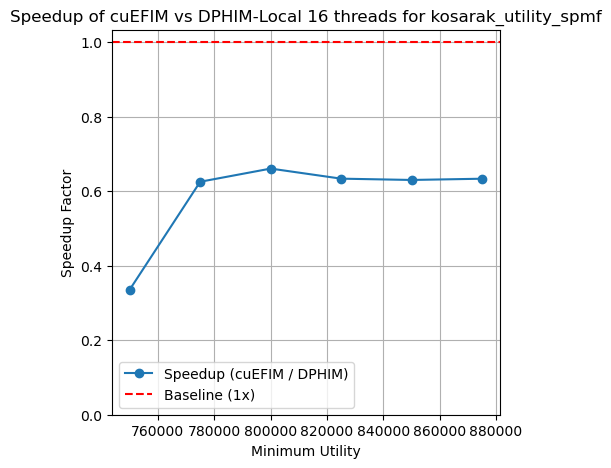

In [10]:
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Initialize a consolidated DataFrame
columns = ["Algorithm", "File", "Minimum_Utility", "Execution_Time", "Frequent_Patterns", "GPU_Memory_Usage", "CPU_Memory_Usage"]
# results_df = pd.DataFrame(columns=columns)
if os.path.exists("combined_results.csv"):
    results_df = pd.read_csv("combined_results.csv")
else:
    results_df = pd.DataFrame(columns=columns)

def save_results():
    """Save results DataFrame to CSV."""
    results_df.to_csv("combined_results.csv", index=False)

def has_run_before(algorithm, file_name, min_util):
    """Check if an algorithm has already processed a file with a specific minimum utility."""
    return not results_df[
        (results_df["Algorithm"] == algorithm) &
        (results_df["File"] == os.path.splitext(os.path.basename(file_name))[0]) &
        (results_df["Minimum_Utility"] == min_util)
    ].empty

def run_efim(process_data):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            if has_run_before("EFIM", file_path, min_util):
                print(f"Skipping EFIM for File: {file_path}, Min Util: {min_util} (Already Processed)")
                continue

            command = [
                "/home/tarun/cudaEFIM/build/efim",
                "-f", file_path,
                "-o", "output.txt",
                "-s", "space",
                "-m", str(min_util),
                "-M", "GPU"
            ]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                output = result.stdout

                execution_time = None
                frequent_patterns = None
                max_gpu_memory = 0.0
                max_cpu_memory = 0

                for line in output.splitlines():
                    if "Execution time:" in line:
                        execution_time = float(line.split("Execution time:")[-1].strip().replace("s", ""))
                        execution_time = int(execution_time * 1000)  # Convert to ms
                    elif "Frequent Patterns:" in line:
                        frequent_patterns = int(line.split("Frequent Patterns:")[-1].strip())
                    elif "Used GPU memory:" in line:
                        current_gpu_memory = float(line.split("Used GPU memory:")[-1].strip().replace("MB", "")) * 1024  # Convert to KB
                        max_gpu_memory = max(max_gpu_memory, current_gpu_memory)
                    elif "Maximum resident set size:" in line:
                        current_cpu_memory = int(line.split("Maximum resident set size:")[-1].strip().replace("KB", ""))
                        max_cpu_memory = max(max_cpu_memory, current_cpu_memory)

                print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}, GPU Memory: {max_gpu_memory}, CPU Memory: {max_cpu_memory}")
                new_entry = {
                    "Algorithm": "EFIM",
                    "File": os.path.splitext(os.path.basename(file_path))[0],
                    "Minimum_Utility": min_util,
                    "Execution_Time": execution_time,
                    "Frequent_Patterns": frequent_patterns,
                    "GPU_Memory_Usage": max_gpu_memory,
                    "CPU_Memory_Usage": max_cpu_memory
                }
                results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                save_results()
            except Exception as e:
                print(f"Error running EFIM: {e}")


def run_dphim(process_data):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            if has_run_before("DPHIM", file_path, min_util):
                print(f"Skipping DPHIM for File: {file_path}, Min Util: {min_util} (Already Processed)")
                continue

            command = [
                "/home/tarun/dphim/build/run",
                "-i", file_path,
                "-m", str(min_util),
                "-s", "local",
                "-t", "16",
                "-o", "/dev/null"
            ]
            try:
                result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                output = result.stdout

                execution_time = None
                frequent_patterns = None
                total_rss = 0  # Initialize total RSS to 0

                for line in output.splitlines():
                    if "Total time ~:" in line:
                        execution_time = int(line.split("Total time ~:")[-1].strip().split(" ")[0])  # Convert to ms
                    elif "High utility itemsets count:" in line:
                        frequent_patterns = int(line.split("High utility itemsets count:")[-1].strip())
                    # elif "RSS" in line:
                    #     rss_value = int(line.split("RSS")[-1].strip().split("MB")[0].strip()) * 1024  # Convert to KB
                    #     total_rss += rss_value  # Add to total RSS

                # take the last 5 lines of the output to get the memory usage
                last_lines = output.splitlines()[-2:]
                for line in last_lines:
                    splitted  = [x for x in line.split(" ") if x]
                    for item in splitted:
                        if "MB" == item:
                            total_rss += int(splitted[splitted.index(item) - 1]) * 1024
                    # print(splitted)
                    # # find the item that contains "MB"
                    # index = splitted.index("MB")
                    # total_rss += int(splitted[index-1]) * 1024 # Convert to KB

                print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}, CPU Memory: {total_rss} KB")
                new_entry = {
                    "Algorithm": "DPHIM",
                    "File": os.path.splitext(os.path.basename(file_path))[0],
                    "Minimum_Utility": min_util,
                    "Execution_Time": execution_time,
                    "Frequent_Patterns": frequent_patterns,
                    "CPU_Memory_Usage": total_rss
                }
                results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                save_results()
            except Exception as e:
                print(f"Error running DPHIM: {e}")


def plot_results(results_df, file_name):
    figure_size = (5, 5)

    filtered_df = results_df[results_df['File'] == os.path.splitext(file_name)[0]]

    # Rename algorithm names for clarity
    filtered_df["Algorithm"] = filtered_df["Algorithm"].apply(lambda x: "cuEFIM" if x == "EFIM" else "DP-Local 16 threads")

    # Combine CPU and GPU memory into a single column
    if "GPU_Memory_Usage" in filtered_df.columns:
        filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"] + filtered_df["GPU_Memory_Usage"].fillna(0)
    else:
        filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"]

    # Plot Execution Time vs Minimum Utility
    plt.figure(figsize=figure_size)
    for algorithm in filtered_df["Algorithm"].unique():
        subset = filtered_df[filtered_df["Algorithm"] == algorithm]
        plt.plot(subset["Minimum_Utility"], subset["Execution_Time"], marker='o', label=f"{algorithm} Execution Time")
    plt.title(f"Execution Time vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Execution Time (ms)")
    # plt.yscale("log", base=10)
    plt.legend()
    plt.grid(True)
    # plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_execution_time.svg")
    # plt.show()

    # Plot Frequent Patterns vs Minimum Utility
    plt.figure(figsize=figure_size)
    for algorithm in filtered_df["Algorithm"].unique():
        subset = filtered_df[filtered_df["Algorithm"] == algorithm]
        plt.plot(subset["Minimum_Utility"], subset["Frequent_Patterns"], marker='o', label=f"{algorithm} Patterns")
    plt.title(f"Frequent Patterns vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Frequent Patterns")
    plt.legend()
    plt.grid(True)
    # plt.xlim(left=0)
    # plt.ylim(bottom=0)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_patterns.svg")
    # plt.show()

    # Plot Total Memory Usage vs Minimum Utility
    plt.figure(figsize=figure_size)
    for algorithm in filtered_df["Algorithm"].unique():
        subset = filtered_df[filtered_df["Algorithm"] == algorithm]
        plt.plot(subset["Minimum_Utility"], subset["Total_Memory_Usage"], marker='o', label=f"{algorithm} Total Memory Usage")
    plt.title(f"Total Memory Usage vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Total Memory Usage (KB)")
    # plt.yscale("log", base=10)
    plt.legend()
    plt.grid(True)
    # plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_total_memory.svg")
    # plt.show()

    # Calculate and Plot Speedup
    cuEFIM_df = filtered_df[filtered_df["Algorithm"] == "cuEFIM"]
    dphim_df = filtered_df[filtered_df["Algorithm"] == "DP-Local 16 threads"]

    if not cuEFIM_df.empty and not dphim_df.empty:
        speedup_df = pd.merge(cuEFIM_df, dphim_df, on="Minimum_Utility", suffixes=('_cuEFIM', '_DPHIM'))
        # speedup_df["Speedup"] = speedup_df["Execution_Time_DPHIM"] / speedup_df["Execution_Time_cuEFIM"]
        speedup_df["Speedup"] = speedup_df["Execution_Time_cuEFIM"] / speedup_df["Execution_Time_DPHIM"]

        plt.figure(figsize=figure_size)
        # plt.plot(speedup_df["Minimum_Utility"], speedup_df["Speedup"], marker='o', label="Speedup (DPHIM / cuEFIM)")
        plt.plot(speedup_df["Minimum_Utility"], speedup_df["Speedup"], marker='o', label="Speedup (cuEFIM / DPHIM)")
        plt.axhline(y=1, color='r', linestyle='--', label="Baseline (1x)")
        plt.title(f"Speedup of cuEFIM vs DPHIM-Local 16 threads for {os.path.splitext(file_name)[0]}")
        plt.xlabel("Minimum Utility")
        plt.ylabel("Speedup Factor")
        # plt.yscale("log", base=10)
        plt.legend()
        plt.grid(True)
        # plt.xlim(left=0)
        plt.ylim(bottom=0)
        plt.savefig(f"{os.path.splitext(file_name)[0]}_speedup.svg")
        # plt.show()
        # put origin at 0,0
        


# Example usage
process_data = [
    ["/home/tarun/cudaEFIM/datasets/chainstore.txt", [150000, 160000, 170000, 180000, 190000, 200000]],
    # ["/home/tarun/cudaEFIM/datasets/BMS_utility_spmf.txt", [2030000, 2035000, 2040000, 2045000, 2050000, 2055000]],
    ["/home/tarun/cudaEFIM/datasets/accidents_utility_spmf.txt", [15000000, 16000000, 17000000, 18000000, 19000000, 20000000]],
    ["/home/tarun/cudaEFIM/datasets/kosarak_utility_spmf.txt", [750000, 775000, 800000, 825000, 850000, 875000]],
]

# Run EFIM and DPHIM
run_efim(process_data)
run_dphim(process_data)

for file_path, _ in process_data:
    plot_results(results_df, file_path.split("/")[-1].split(".")[0])
    # plot_results_with_broken_axes(results_df, file_path.split("/")[-1].split(".")[0])
